In [1]:
import requests
import json
import pandas as pd
from pandas import json_normalize
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Polygon
import numpy as np

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="IT"][admin_level=2]->.search;
way[waterway="river"](area.search);
out geom;"""

response = requests.get(overpass_url, params={'data': overpass_query})
data=response.json()['elements']

df = json_normalize(data)

In [3]:
df1 = df.explode('geometry')
df2 = pd.json_normalize(df1['geometry'])
df3 = df.explode('nodes')
df4 = pd.concat([df2.reset_index(drop=True),df3.reset_index(drop=True)], axis=1)

In [4]:
gdf = gpd.GeoDataFrame(
    df4, geometry=gpd.points_from_xy(df4['lon'], df4['lat']))

# display(gdf)

In [5]:
# Sort and group points to make lines

line_gdf = gdf.sort_values(by=['nodes']).groupby(['id'])['geometry'].apply(lambda x: LineString(x.tolist()))
line_gdf = gpd.GeoDataFrame(line_gdf, geometry='geometry')

# display(line_gdf)

# Saving geometry
line_gdf.crs = "EPSG:4326"
# line_gdf.to_file("lines.shp")

In [6]:
# Grids

# points = gpd.read_file('lines.shp')
xmin,ymin,xmax,ymax =  line_gdf.total_bounds
width = 0.1
height = 0.1
rows = int(np.ceil((ymax-ymin) /  height))
cols = int(np.ceil((xmax-xmin) / width))
XleftOrigin = xmin
XrightOrigin = xmin + width
YtopOrigin = ymax
YbottomOrigin = ymax- height
polygons = []
for i in range(cols):
    Ytop = YtopOrigin
    Ybottom =YbottomOrigin
    for j in range(rows):
        polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])) 
        Ytop = Ytop - height
        Ybottom = Ybottom - height
    XleftOrigin = XleftOrigin + width
    XrightOrigin = XrightOrigin + width

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.crs = "EPSG:4326"
# grid.to_file("grid.shp")

In [7]:
line_gdf.reset_index(inplace = True)
grid.reset_index(inplace = True)
# grid.head()
# line_gdf.head()

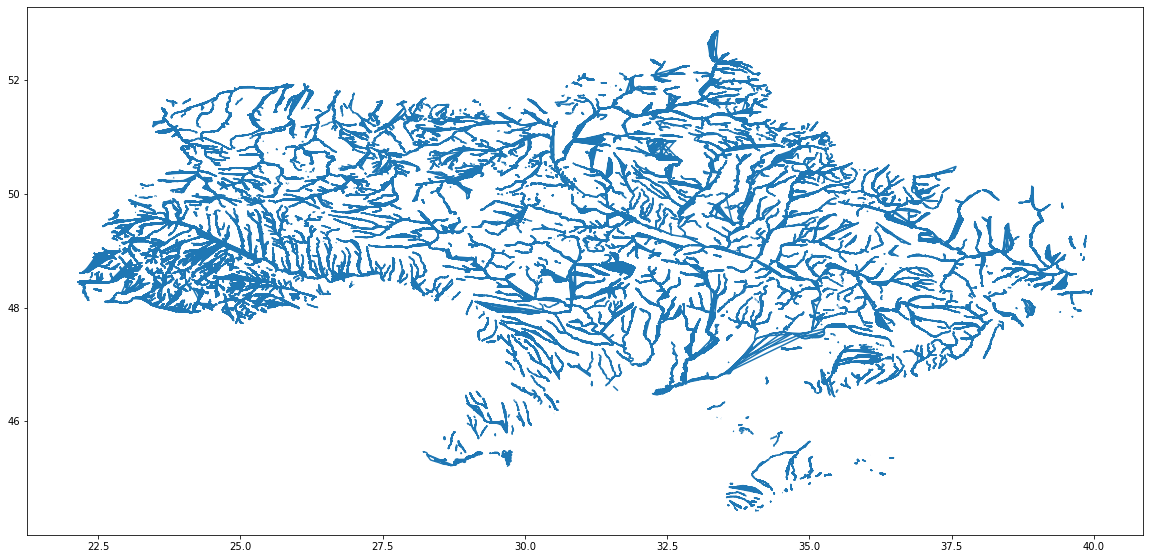

In [9]:
line_gdf.plot(figsize=(20,10))

In [ ]:
overlay = gpd.overlay(line_gdf, grid, how='intersection', keep_geom_type=True)
overlay['length_w']=overlay['geometry'].length
# overlay.head()
# overlay.plot()

In [11]:
overlay1=overlay.groupby('index')['length_w'].sum()
# overlay1.head()

In [12]:
grid1=pd.merge(grid, overlay1, left_on='index', right_on='index', how='left')
grid1.head(276)
# gpd.io.file.infer_schema(grid1)

,index,geometry,length_w
0,0,"POLYGON ((123.68988 45.43694, 123.78988 45.436...",NaN
1,1,"POLYGON ((123.68988 45.33694, 123.78988 45.336...",NaN
2,2,"POLYGON ((123.68988 45.23694, 123.78988 45.236...",NaN
3,3,"POLYGON ((123.68988 45.13694, 123.78988 45.136...",NaN
4,4,"POLYGON ((123.68988 45.03694, 123.78988 45.036...",NaN
...,...,...,...
271,271,"POLYGON ((123.78988 39.53694, 123.88988 39.536...",NaN
272,272,"POLYGON ((123.78988 39.43694, 123.88988 39.436...",NaN
273,273,"POLYGON ((123.78988 39.33694, 123.88988 39.336...",NaN
274,274,"POLYGON ((123.78988 39.23694, 123.88988 39.236...",NaN


In [13]:
grid1=grid1.drop(['geometry'], axis=1)
grid1 = grid1.fillna(0)
grid1.head(276)
# grid1.to_csv("grid1.csv")

,index,length_w
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
271,271,0.0
272,272,0.0
273,273,0.0
274,274,0.0


# Service roads

In [14]:
overpass_url2 = "http://overpass-api.de/api/interpreter"
overpass_query2 = """
[out:json];
area["ISO3166-1"="JP"][admin_level=2]->.search;
way[highway="service"](area.search);
out geom;"""

response2 = requests.get(overpass_url2, params={'data': overpass_query2})
data2=response2.json()['elements']

dr = json_normalize(data2)
# my_list1 = list(df1)
# print (my_list1)

In [15]:
dr1 = dr.explode('geometry')
dr2 = pd.json_normalize(dr1['geometry'])
dr3 = dr.explode('nodes')
dr4 = pd.concat([dr2.reset_index(drop=True),dr3.reset_index(drop=True)], axis=1)

In [16]:
gdr = gpd.GeoDataFrame(
    dr4, geometry=gpd.points_from_xy(dr4['lon'], dr4['lat']))

# display(gdf)

In [17]:
# Sort and group points to make lines

line_gdr = gdr.sort_values(by=['nodes']).groupby(['id'])['geometry'].apply(lambda x: LineString(x.tolist()))
line_gdr = gpd.GeoDataFrame(line_gdr, geometry='geometry')

# display(line_gdf)

# Saving geometry
line_gdr.crs = "EPSG:4326"
# line_gdf.to_file("lines.shp")

In [18]:
line_gdr.reset_index(inplace = True)

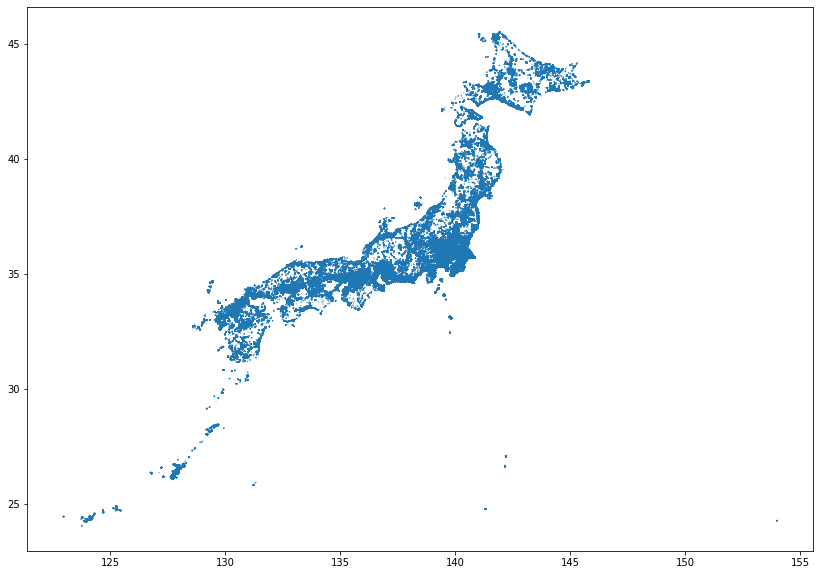

In [19]:
line_gdr.plot(figsize=(20,10))

In [20]:
overlay_r = gpd.overlay(line_gdr, grid, how='intersection', keep_geom_type=True)
overlay_r['length_r']=overlay_r['geometry'].length
# overlay.head()
# overlay.plot()

In [21]:
overlay_r1=overlay_r.groupby('index')['length_r'].sum()
# overlay1.head()

In [22]:
gridr=pd.merge(grid1, overlay_r1, left_on='index', right_on='index', how='left')
# grid1.head(276)
# gpd.io.file.infer_schema(grid1)

In [23]:
gridr.head()

,index,length_w,length_r
0,0,0.0,NaN
1,1,0.0,NaN
2,2,0.0,NaN
3,3,0.0,NaN
4,4,0.0,NaN


In [24]:
gridr = gridr.fillna(0)
gridr.head(276)
# grid1.to_csv("grid1.csv")

,index,length_w,length_r
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0
...,...,...,...
271,271,0.0,0.0
272,272,0.0,0.0
273,273,0.0,0.0
274,274,0.0,0.0


In [25]:
grid.head()

,index,geometry
0,0,"POLYGON ((123.68988 45.43694, 123.78988 45.436..."
1,1,"POLYGON ((123.68988 45.33694, 123.78988 45.336..."
2,2,"POLYGON ((123.68988 45.23694, 123.78988 45.236..."
3,3,"POLYGON ((123.68988 45.13694, 123.78988 45.136..."
4,4,"POLYGON ((123.68988 45.03694, 123.78988 45.036..."


In [26]:
grid3a=pd.merge(grid, gridr, left_on='index', right_on='index', how='left')
grid3a.head()

,index,geometry,length_w,length_r
0,0,"POLYGON ((123.68988 45.43694, 123.78988 45.436...",0.0,0.0
1,1,"POLYGON ((123.68988 45.33694, 123.78988 45.336...",0.0,0.0
2,2,"POLYGON ((123.68988 45.23694, 123.78988 45.236...",0.0,0.0
3,3,"POLYGON ((123.68988 45.13694, 123.78988 45.136...",0.0,0.0
4,4,"POLYGON ((123.68988 45.03694, 123.78988 45.036...",0.0,0.0


# Railways

In [27]:
overpass_url1 = "http://overpass-api.de/api/interpreter"
overpass_query1 = """
[out:json];
area["ISO3166-1"="JP"][admin_level=2]->.search;
way[railway="rail"](area.search);
out geom;"""

response1 = requests.get(overpass_url1, params={'data': overpass_query1})
data1=response1.json()['elements']

dw = json_normalize(data1)
# my_list1 = list(df1)
# print (my_list1)

In [28]:
dw1 = dw.explode('geometry')
dw2 = pd.json_normalize(dw1['geometry'])
dw3 = dw.explode('nodes')
dw4 = pd.concat([dw2.reset_index(drop=True),dw3.reset_index(drop=True)], axis=1)

In [29]:
gdw = gpd.GeoDataFrame(
    dw4, geometry=gpd.points_from_xy(dw4['lon'], dw4['lat']))

# display(gdf)

In [30]:
# Sort and group points to make lines

line_gdw = gdw.sort_values(by=['nodes']).groupby(['id'])['geometry'].apply(lambda x: LineString(x.tolist()))
line_gdw = gpd.GeoDataFrame(line_gdw, geometry='geometry')

# display(line_gdf)

# Saving geometry
line_gdw.crs = "EPSG:4326"
# line_gdf.to_file("lines.shp")

In [31]:
line_gdf.reset_index(inplace = True)
grid.reset_index(inplace = True)
# grid.head()
# line_gdf.head()

line_gdw.reset_index(inplace = True)

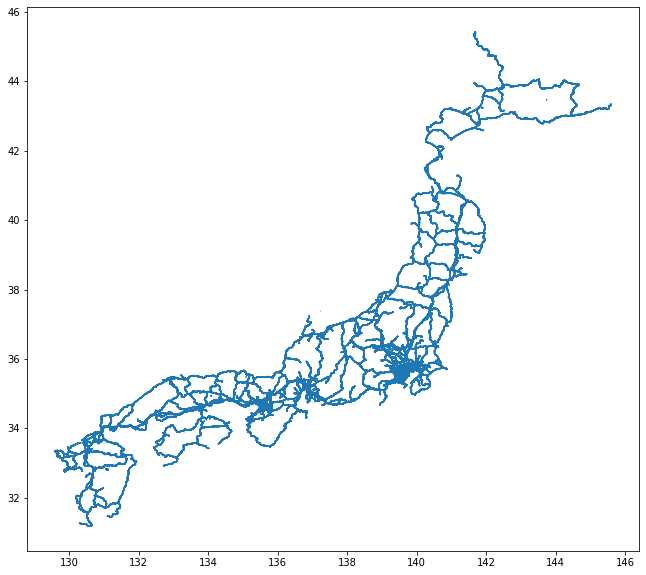

In [32]:
line_gdw.plot(figsize=(20,10))

In [33]:
overlay_w = gpd.overlay(line_gdw, grid, how='intersection', keep_geom_type=True)
overlay_w['length']=overlay_w['geometry'].length
# overlay.head()
# overlay.plot()

In [34]:
overlay_w1=overlay_w.groupby('index')['length'].sum()
# overlay1.head()

In [35]:
grid2=pd.merge(grid1, overlay_w1, left_on='index', right_on='index', how='left')
# grid1.head(276)
# gpd.io.file.infer_schema(grid1)

In [36]:
grid2.head()

,index,length_w,length
0,0,0.0,NaN
1,1,0.0,NaN
2,2,0.0,NaN
3,3,0.0,NaN
4,4,0.0,NaN


In [37]:
grid2 = grid2.fillna(0)
grid2.head(276)
# grid1.to_csv("grid1.csv")

,index,length_w,length
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0
...,...,...,...
271,271,0.0,0.0
272,272,0.0,0.0
273,273,0.0,0.0
274,274,0.0,0.0


In [38]:
grid.head()

,level_0,index,geometry
0,0,0,"POLYGON ((123.68988 45.43694, 123.78988 45.436..."
1,1,1,"POLYGON ((123.68988 45.33694, 123.78988 45.336..."
2,2,2,"POLYGON ((123.68988 45.23694, 123.78988 45.236..."
3,3,3,"POLYGON ((123.68988 45.13694, 123.78988 45.136..."
4,4,4,"POLYGON ((123.68988 45.03694, 123.78988 45.036..."


In [39]:
grid3=pd.merge(grid3a, grid2, left_on='index', right_on='index', how='left')
grid3.head()

,index,geometry,length_w_x,length_r,length_w_y,length
0,0,"POLYGON ((123.68988 45.43694, 123.78988 45.436...",0.0,0.0,0.0,0.0
1,1,"POLYGON ((123.68988 45.33694, 123.78988 45.336...",0.0,0.0,0.0,0.0
2,2,"POLYGON ((123.68988 45.23694, 123.78988 45.236...",0.0,0.0,0.0,0.0
3,3,"POLYGON ((123.68988 45.13694, 123.78988 45.136...",0.0,0.0,0.0,0.0
4,4,"POLYGON ((123.68988 45.03694, 123.78988 45.036...",0.0,0.0,0.0,0.0


# Import cement & steel training points

In [40]:
import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

data1=pd.read_csv('/Users/natashalove/Downloads/cement_steel_training_dataset_v4.csv', sep=',', engine='python')
data1 = data1.fillna(0)

points1 = gpd.GeoDataFrame(data1, geometry=gpd.points_from_xy(data1.longitude, data1.latitude))
points1.crs = "EPSG:4326"
points1.head()


,iso3,uid,uid_ind,country,plant_type,latitude,longitude,kiln_type_1,capacity,crude_steel,owner_steel,product,geometry
0,ALB,ALB0003,ALB0003_c,Albania,Grinding,41.120103,20.045136,0,0.15,0.0,0,cement,POINT (20.04514 41.12010)
1,ALB,ALB0005,ALB0005_c,Albania,Grinding,41.836770,19.633450,0,0.50,0.0,0,cement,POINT (19.63345 41.83677)
2,AGO,AGO0001,AGO0001_c,Angola,Grinding,-12.537825,13.496729,0,0.40,0.0,0,cement,POINT (13.49673 -12.53782)
3,AGO,AGO0002,AGO0002_c,Angola,Grinding,-12.342644,13.581766,0,0.30,0.0,0,cement,POINT (13.58177 -12.34264)
4,ARG,ARG0007,ARG0007_c,Argentina,Grinding,-31.444889,-64.370470,DRY,0.50,0.0,0,cement,POINT (-64.37047 -31.44489)


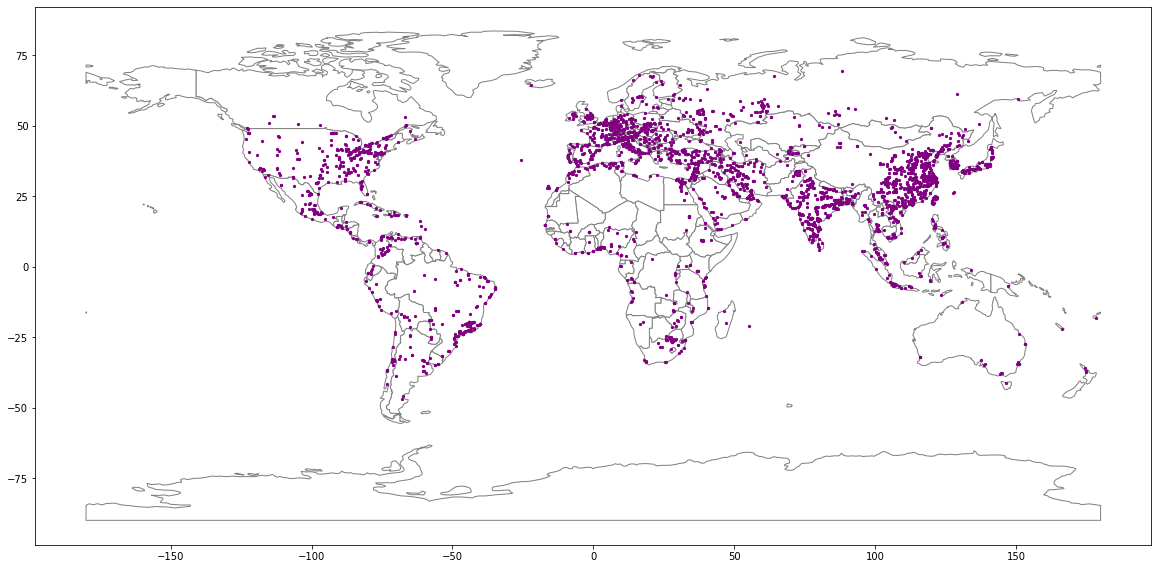

In [41]:
import geoplot
import geoplot.crs as gcrs

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='grey', figsize=(20,10))
points1.plot(ax=base, marker='o', color='purple', markersize=5, figsize=(20,10))

#points1.plot(figsize=(20,10))

In [42]:
# Select points by country

CHN1 = points1.loc[points1['iso3'] == 'JPN']
len(CHN1.index)

85

In [58]:
# Select points by industry type

CHN = CHN1.loc[CHN1['product'] == 'steel']
len(CHN.index)

55

In [59]:
# Link country-grid with selected points

#steel_grids_china = gpd.sjoin(CHN, grid3, op="within")
steel_grids_china = gpd.sjoin(grid3, CHN)
steel_grids_china['Count_pnt'] = 1
steel_grids_china1=steel_grids_china.groupby(by='index')['Count_pnt'].sum()
steel_grids_china1.head(100)

index
8883     1
15167    1
15802    1
16869    1
17073    1
17498    1
18767    1
18768    1
20042    1
20239    1
20673    1
21309    1
23214    3
23426    1
23639    1
24280    1
24487    1
24492    1
24911    2
24912    3
25334    1
27875    2
27876    3
28071    1
28089    1
28727    1
28939    1
32525    1
33163    1
34017    1
34019    1
34223    1
34232    1
34441    1
34644    1
34866    1
35072    1
35922    1
35923    1
36135    1
36495    2
36706    1
36747    1
37382    2
37572    1
Name: Count_pnt, dtype: int64

In [60]:
grid4=pd.merge(grid3, steel_grids_china1, left_on='index', right_on='index', how='left')
grid4 = grid4.fillna(0)
grid4.head(3)
#grid4.to_csv("grid10km.csv")
#grid4.to_file("grid10km_shp.shp")

,index,geometry,length_w_x,length_r,length_w_y,length,Count_pnt
0,0,"POLYGON ((123.68988 45.43694, 123.78988 45.436...",0.0,0.0,0.0,0.0,0.0
1,1,"POLYGON ((123.68988 45.33694, 123.78988 45.336...",0.0,0.0,0.0,0.0,0.0
2,2,"POLYGON ((123.68988 45.23694, 123.78988 45.236...",0.0,0.0,0.0,0.0,0.0


In [61]:
index = grid4.index
number_of_rows = len(index)
print(number_of_rows)

46428


In [62]:
length_r = grid4['length'].sum()
print (length_r)

1549.3245347852467


In [63]:
length_w = grid4['length_w_x'].sum()
print (length_w)

48030.36427576743


In [64]:
grid4['prop_rail'] = grid4['length']/grid4['length'].sum()
grid4['prop_water'] = grid4['length_w_x']/grid4['length_w_x'].sum()
grid4['prop_road'] = grid4['length_r']/grid4['length_r'].sum()

# Building MLR prediction

In [65]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = grid4[['prop_rail', 'prop_water','prop_road']]
y = grid4['Count_pnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
prop_rail,22.727174
prop_water,-21.640671
prop_road,43.830912


In [67]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
41666,0.0,0.000337
37194,0.0,0.000337
40763,0.0,0.000337
17867,0.0,0.000337
42347,0.0,0.000337
...,...,...
20147,0.0,0.000337
20242,0.0,-0.011707
39448,0.0,0.104101
30553,0.0,0.000337


In [68]:
#from sklearn import metrics
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [69]:
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
predictions

array([0.00030655, 0.00030655, 0.00030655, ..., 0.00030655, 0.00030655,
       0.00030655])

In [70]:
grid4['preds'] = pd.Series(predictions)
grid4.head(10)

,index,geometry,length_w_x,length_r,length_w_y,length,Count_pnt,prop_rail,prop_water,prop_road,preds
0,0,"POLYGON ((123.68988 45.43694, 123.78988 45.436...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000307
1,1,"POLYGON ((123.68988 45.33694, 123.78988 45.336...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000307
2,2,"POLYGON ((123.68988 45.23694, 123.78988 45.236...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000307
3,3,"POLYGON ((123.68988 45.13694, 123.78988 45.136...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000307
4,4,"POLYGON ((123.68988 45.03694, 123.78988 45.036...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000307
5,5,"POLYGON ((123.68988 44.93694, 123.78988 44.936...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000307
6,6,"POLYGON ((123.68988 44.83694, 123.78988 44.836...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000307
7,7,"POLYGON ((123.68988 44.73694, 123.78988 44.736...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000307
8,8,"POLYGON ((123.68988 44.63694, 123.78988 44.636...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000307
9,9,"POLYGON ((123.68988 44.53694, 123.78988 44.536...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000307


In [71]:
# How many points in total
grid4['Count_pnt'].sum()

# Outside infrastructure

55.0

In [72]:
# How many points inside infrastructure

grid5 = grid4[grid4['Count_pnt'] > 0]
grid4a = grid4[grid4['preds'] > grid5['preds'].min()]
grid4a['Count_pnt'].sum()
grid4a['Count_pnt'].sum()/grid4['Count_pnt'].sum()

0.9636363636363636

In [73]:
# How many 'escaped' points outside infrastructure?

grid4b = grid4[grid4['preds'] <= grid5['preds'].min()]
grid4b['Count_pnt'].sum()
grid4b['Count_pnt'].sum()/grid4['Count_pnt'].sum()

0.03636363636363636

In [105]:
grid4a.to_file("macroloc_cement_CHN_10_correct1.shp")

# Machine learning categories

In [1]:
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [2]:
import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

data1=pd.read_csv('/Users/natashalove/Downloads/cem_steel_bal_china.csv', sep=',', engine='python')
data1 = data1.fillna(0)

points1 = gpd.GeoDataFrame(data1, geometry=gpd.points_from_xy(data1.longitude, data1.latitude))
points1.crs = "EPSG:4326"
points1.head()

,iso3,uid,uid_ind,country,plant_type,latitude,longitude,kiln_type_1,capacity,crude_steel,owner_steel,product,geometry
0,CHN,CHN0003,CHN0003_c,China,Grinding,28.492576,115.951121,0,1.5,0.0,0,cement,POINT (115.95112 28.49258)
1,CHN,CHN0004,CHN0004_c,China,Grinding,31.355912,121.517068,0,0.9,0.0,0,cement,POINT (121.51707 31.35591)
2,CHN,CHN0005,CHN0005_c,China,Grinding,32.923638,117.439757,0,2.4,0.0,0,cement,POINT (117.43976 32.92364)
3,CHN,CHN0007,CHN0007_c,China,Grinding,31.006610,121.442527,0,2.1,0.0,0,cement,POINT (121.44253 31.00661)
4,CHN,CHN0008,CHN0008_c,China,Grinding,31.993157,120.576024,0,3.2,0.0,0,cement,POINT (120.57602 31.99316)


In [ ]:
from shapely.geometry import Point
import geopandas as gpd
import random

def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i=0
    while i<number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points

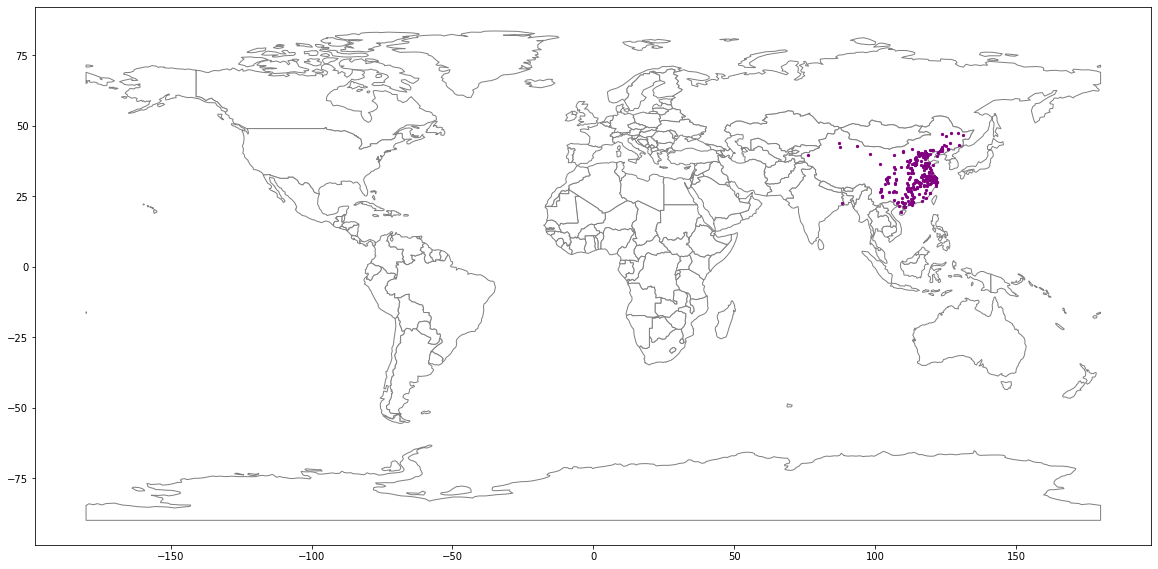

In [3]:
import geoplot
import geoplot.crs as gcrs

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='grey', figsize=(20,10))
points1.plot(ax=base, marker='o', color='purple', markersize=5, figsize=(20,10))

#points1.plot(figsize=(20,10))

In [4]:
# Select points by country

CHN = points1.loc[points1['iso3'] == 'CHN']
#CHN.head()

In [5]:
# Link country-grid with selected points

steel_grids_china = gpd.sjoin(CHN, grid3, op="within")
steel_grids_china.head(10)

NameError: name 'grid3' is not defined

In [102]:
steel_grids_china['prop_rail'] = steel_grids_china['length']/grid3['length'].sum()
steel_grids_china['prop_water'] = steel_grids_china['length_w']/grid3['length_w'].sum()

steel_grids_china.head(2)

,iso3,uid,uid_ind,country,plant_type,latitude,longitude,kiln_type_1,capacity,crude_steel,owner_steel,product,geometry,index_right,index,length,length_w,prop_rail,prop_water
0,CHN,CHN0003,CHN0003_c,China,Grinding,28.492576,115.951121,0,1.5,0.0,0,cement,POINT (115.95112 28.49258),555795,555795,1.749329,0.058325,0.000207,0.000002
1,CHN,CHN0004,CHN0004_c,China,Grinding,31.355912,121.517068,0,0.9,0.0,0,cement,POINT (121.51707 31.35591),633578,633578,1.160608,0.463050,0.000137,0.000014


In [103]:
SGC_prod = steel_grids_china[['product', 'length', 'length_w']]
SGC_type = steel_grids_china[['plant_type', 'length', 'length_w']]

In [104]:
print(SGC_prod.describe())
print(SGC_type.describe())

           length    length_w
count  325.000000  325.000000
mean     0.448950    0.250279
std      0.919119    0.464104
min      0.000000    0.000000
25%      0.000000    0.000000
50%      0.178903    0.094252
75%      0.503962    0.269020
max     10.696128    3.550595
           length    length_w
count  325.000000  325.000000
mean     0.448950    0.250279
std      0.919119    0.464104
min      0.000000    0.000000
25%      0.000000    0.000000
50%      0.178903    0.094252
75%      0.503962    0.269020
max     10.696128    3.550595


In [105]:
print(SGC_prod.groupby('product').size())

product
cement    162
steel     163
dtype: int64


In [106]:
print(SGC_type.groupby('plant_type').size())

plant_type
BF            107
EAF            56
Grinding       38
Integrated    124
dtype: int64


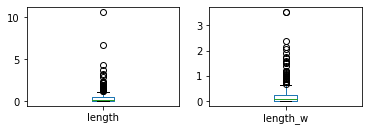

In [120]:
SGC_type.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
pyplot.show()

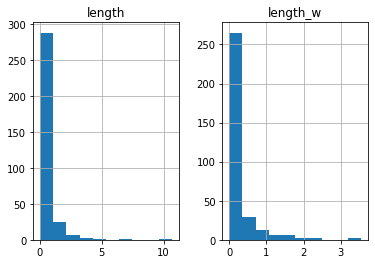

In [121]:
SGC_type.hist()
pyplot.show()

In [122]:
SGC_prod.head()

,product,length,length_w
0,cement,1.749329,0.058325
1,cement,1.160608,0.463050
2,cement,3.193246,0.786633
3,cement,0.000000,1.510480
4,cement,0.000000,0.251056


In [123]:
SGC_type.head()

,plant_type,length,length_w
0,Grinding,1.749329,0.058325
1,Grinding,1.160608,0.463050
2,Grinding,3.193246,0.786633
3,Grinding,0.000000,1.510480
4,Grinding,0.000000,0.251056


In [128]:
array = SGC_prod.values
X = array[:,1:2]
y = array[:,0]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size = 0.10, random_state = 1)

In [129]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.587594 (0.081286)
LDA: 0.601043 (0.085662)
KNN: 0.567841 (0.033531)
CART: 0.524171 (0.056373)
NB: 0.561273 (0.079765)
SVM: 0.587471 (0.089506)


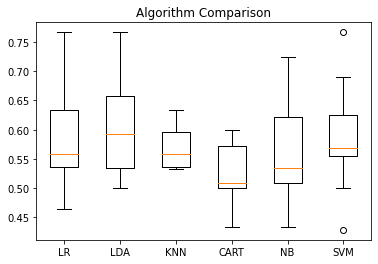

In [130]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [131]:
model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.696969696969697
[[15  2]
 [ 8  8]]
              precision    recall  f1-score   support

      cement       0.65      0.88      0.75        17
       steel       0.80      0.50      0.62        16

    accuracy                           0.70        33
   macro avg       0.73      0.69      0.68        33
weighted avg       0.72      0.70      0.68        33



In [132]:
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.696969696969697
[[15  2]
 [ 8  8]]
              precision    recall  f1-score   support

      cement       0.65      0.88      0.75        17
       steel       0.80      0.50      0.62        16

    accuracy                           0.70        33
   macro avg       0.73      0.69      0.68        33
weighted avg       0.72      0.70      0.68        33



In [133]:
model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.5454545454545454
[[12  5]
 [10  6]]
              precision    recall  f1-score   support

      cement       0.55      0.71      0.62        17
       steel       0.55      0.38      0.44        16

    accuracy                           0.55        33
   macro avg       0.55      0.54      0.53        33
weighted avg       0.55      0.55      0.53        33



In [134]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.6060606060606061
[[14  3]
 [10  6]]
              precision    recall  f1-score   support

      cement       0.58      0.82      0.68        17
       steel       0.67      0.38      0.48        16

    accuracy                           0.61        33
   macro avg       0.62      0.60      0.58        33
weighted avg       0.62      0.61      0.58        33



In [135]:
model = GaussianNB()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.6060606060606061
[[17  0]
 [13  3]]
              precision    recall  f1-score   support

      cement       0.57      1.00      0.72        17
       steel       1.00      0.19      0.32        16

    accuracy                           0.61        33
   macro avg       0.78      0.59      0.52        33
weighted avg       0.78      0.61      0.53        33



In [136]:
model = SVC(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.696969696969697
[[14  3]
 [ 7  9]]
              precision    recall  f1-score   support

      cement       0.67      0.82      0.74        17
       steel       0.75      0.56      0.64        16

    accuracy                           0.70        33
   macro avg       0.71      0.69      0.69        33
weighted avg       0.71      0.70      0.69        33



##### Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate. We have got 0.788 precision which is pretty good.

### Precision = TP/TP+FP

##### Recall (sensitivity) is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label? We have got recall of 0.631 which is good for this model as it’s above 0.5.

### Recall = TP/TP+FN

##### F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.701.

### F1 Score = 2*(Recall * Precision) / (Recall + Precision)